Clustering of S&P500 stocks based on annual return and volatility

In [1]:
!pip install --upgrade pip

  Using cached pip-24.0-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.0-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\Python310\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install yfinance


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,4]

In [4]:
import pandas as pd
import datetime
import numpy as np
import math


In [5]:
!pip install --upgrade kneed


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
from sklearn.cluster import KMeans, DBSCAN
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

Calculating Drift independent volatility by Yang and Zhang

In [24]:
def DIV(Open, High, Low, Close, N):
    df = pd.DataFrame(index = Close.index)
    df['o'] = np.log(Open/Close.shift(1))
    df['u'] = np.log(High/Open)
    df['d'] = np.log(Low/Open)
    df['c'] = np.log(Close/Open)
    V_zero = df['o'].rolling(N).var()
    V_c = df['c'].rolling(N).var()
    V_rs = (df['u']*(df['u']-df['c']) + df['d']*(df['d']-df['c'])).rolling(N).mean()
    k = 0.34/(1.34 + (N+1)/(N-1))
    V = V_zero + k*V_c + (1-k)*V_rs
    return np.sqrt(V)

In [20]:
sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
data_table = pd.read_html(sp500_url)


In [21]:
data_table[0]

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [22]:
tickers = data_table[0]['Symbol'].values.tolist()
tickers = [s.replace('.', '-')for s in tickers]


In [25]:

s_date = '2020-01-01'
e_date = '2024-01-01'
return_list = []
div_list = []
new_tickers = []

for ticker in tickers[:50]:  # Assuming `tickers` is a list of ticker symbols
    try:
        # Attempt to download data for the current ticker
        tmp = yf.download(ticker, start=s_date, end=e_date,
                          progress=False, auto_adjust=True, interval='1d')  # Use '1d' for daily data
        
        # Check if data was successfully retrieved
        if not tmp.empty:
            tmp['R'] = np.log(tmp['Close'] / tmp['Close'].shift())
            
            # Calculating variance
            tmp['DIV'] = DIV(tmp['Open'], tmp['High'], tmp['Low'], tmp['Close'], 22) ** 2
            tmp.dropna(inplace=True)
            tmp.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
            tmp_1 = pd.DataFrame()
            tmp_2 = pd.DataFrame()
            
            # Clustering on the basis of annual return and volatility
            tmp_1[ticker] = tmp['R'].resample('Y').sum()
            tmp_2[ticker] = tmp['DIV'].resample('Y').sum() ** (0.5)
            
            return_list.append(tmp_1)
            div_list.append(tmp_2)
            new_tickers.append(ticker)
    except Exception as e:
        print(f"Failed to download data for ticker {ticker}: {str(e)}")
        continue  


In [26]:
df_1 = pd.concat(return_list, axis = 1).T
df_1.bfill(inplace = True, axis = 'columns')
df_1

Date,2020-12-31,2021-12-31,2022-12-31,2023-12-31
MMM,0.153718,0.053519,-0.343161,-0.022241
AOS,0.274869,0.465483,-0.386755,0.383065
ABT,0.240640,0.266420,-0.231704,0.022355
ABBV,0.304320,0.280854,0.215174,-0.002351
ACN,0.240816,0.474153,-0.426994,0.289643
ADBE,0.334315,0.125617,-0.521778,0.572560
AMD,0.647014,0.450487,-0.798276,0.822375
AES,0.172601,0.057755,0.196290,-0.369266
AFL,-0.129214,0.296756,0.234369,0.160102
A,0.372722,0.303872,-0.056811,-0.066370


In [27]:
df_2 = pd.concat(div_list, axis=1).T
df_2.bfill(inplace= True, axis='columns')
df_2

Date,2020-12-31,2021-12-31,2022-12-31,2023-12-31
MMM,0.363587,0.189466,0.274017,0.257823
AOS,0.393322,0.263602,0.310245,0.257456
ABT,0.413122,0.214969,0.262290,0.200873
ABBV,0.393452,0.225267,0.267102,0.206292
ACN,0.421407,0.206181,0.332285,0.234000
ADBE,0.484720,0.273263,0.442679,0.314259
AMD,0.597470,0.408404,0.588865,0.458055
AES,0.610928,0.294308,0.355664,0.314260
AFL,0.566113,0.222218,0.256156,0.199197
A,0.378362,0.230701,0.339693,0.302068


In [28]:
df = df_1.join(df_2, rsuffix='_')
df

Date,2020-12-31 00:00:00,2021-12-31 00:00:00,2022-12-31 00:00:00,2023-12-31 00:00:00,2020-12-31 00:00:00_,2021-12-31 00:00:00_,2022-12-31 00:00:00_,2023-12-31 00:00:00_
MMM,0.153718,0.053519,-0.343161,-0.022241,0.363587,0.189466,0.274017,0.257823
AOS,0.274869,0.465483,-0.386755,0.383065,0.393322,0.263602,0.310245,0.257456
ABT,0.240640,0.266420,-0.231704,0.022355,0.413122,0.214969,0.262290,0.200873
ABBV,0.304320,0.280854,0.215174,-0.002351,0.393452,0.225267,0.267102,0.206292
ACN,0.240816,0.474153,-0.426994,0.289643,0.421407,0.206181,0.332285,0.234000
ADBE,0.334315,0.125617,-0.521778,0.572560,0.484720,0.273263,0.442679,0.314259
AMD,0.647014,0.450487,-0.798276,0.822375,0.597470,0.408404,0.588865,0.458055
AES,0.172601,0.057755,0.196290,-0.369266,0.610928,0.294308,0.355664,0.314260
AFL,-0.129214,0.296756,0.234369,0.160102,0.566113,0.222218,0.256156,0.199197
A,0.372722,0.303872,-0.056811,-0.066370,0.378362,0.230701,0.339693,0.302068


In [29]:
df.isna().sum()

Date
2020-12-31 00:00:00     0
2021-12-31 00:00:00     0
2022-12-31 00:00:00     0
2023-12-31 00:00:00     0
2020-12-31 00:00:00_    0
2021-12-31 00:00:00_    0
2022-12-31 00:00:00_    0
2023-12-31 00:00:00_    0
dtype: int64

In [30]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df.values)
pca = PCA(n_components = 2)
pca_scaled = pca.fit_transform(X_scaled)
pca_scaled.shape

<IPython.core.display.Javascript object>

(50, 2)

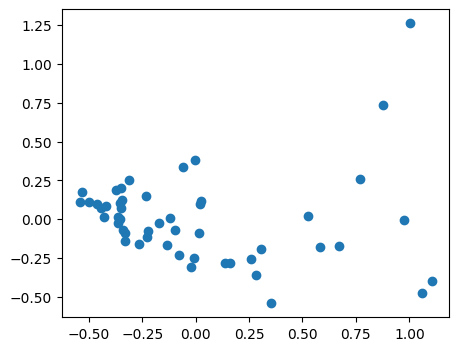

In [31]:
plt.scatter(pca_scaled[:,0], pca_scaled[:,1])
plt.show()

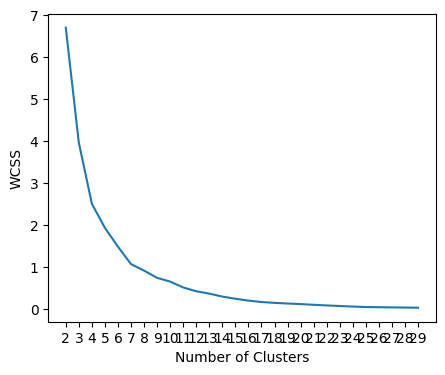

In [35]:
n_clusters = range(2,30)
wcss =[]
for k in n_clusters:
    kmeans = KMeans(n_clusters = k, init= 'k-means++')
    kmeans.fit(pca_scaled)
    wcss.append(kmeans.inertia_)
    
    # ploting elbow curve to get optimal numbers of clusters
plt.plot(n_clusters, wcss)
plt.xticks(n_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [36]:
KneeLocator(n_clusters, wcss, curve='convex', direction='decreasing').elbow

7

In [37]:
pipe = Pipeline([('normalization', MinMaxScaler()),
                 ('pca', PCA(n_components = 2)),
                 ('cluster', KMeans(n_clusters = 7, init='k-means++'))])

pipe.fit(df.values)
labels = pipe.predict(df.values)
labels

<IPython.core.display.Javascript object>

array([6, 0, 6, 2, 6, 0, 4, 5, 2, 6, 2, 1, 6, 1, 6, 4, 6, 2, 2, 0, 0, 2,
       0, 2, 2, 3, 2, 5, 5, 6, 2, 5, 6, 2, 6, 6, 0, 2, 3, 0, 1, 1, 2, 2,
       1, 2, 6, 2, 2, 0])

In [42]:
clusters = pd.DataFrame(data = {'Cluster':labels, 'Symbol':new_tickers})
clusters.sort_values(by=['Cluster'], axis=0, inplace = True)
clusters = clusters.reset_index(drop = True)
clusters

,Cluster,Symbol
0,0,ADSK
1,0,GOOG
2,0,GOOGL
3,0,ANSS
4,0,AAPL
5,0,AMZN
6,0,AOS
7,0,ADBE
8,1,ABNB
9,1,APTV


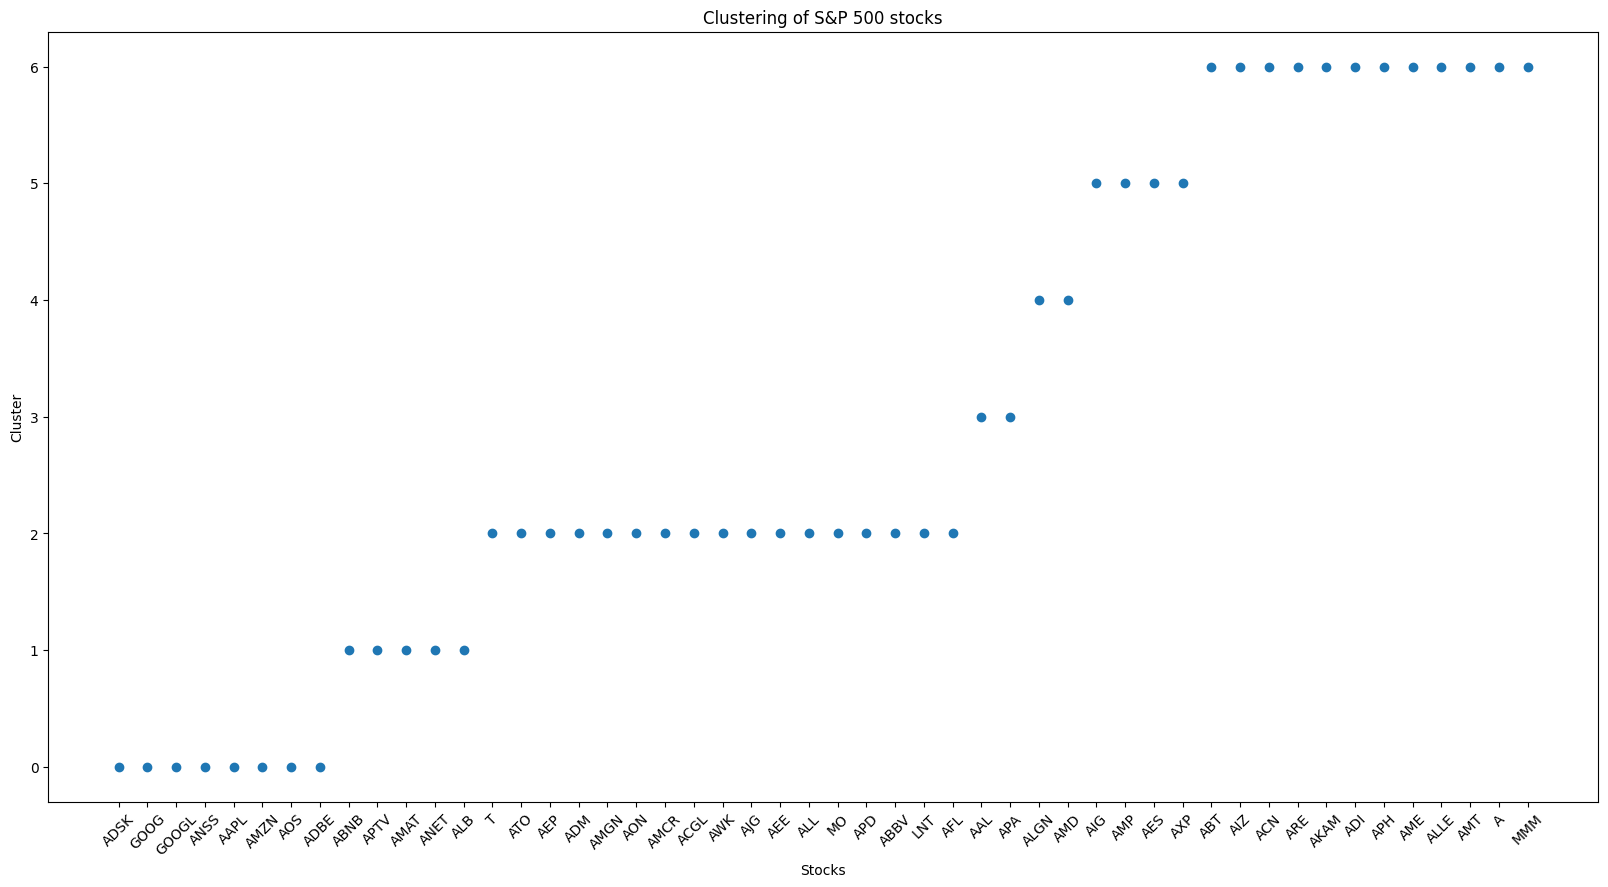

In [43]:
plt.figure(figsize=(20,10))
plt.scatter(clusters.Symbol, clusters.Cluster)
plt.xticks(rotation=45)
plt.xlabel('Stocks')
plt.ylabel('Cluster')
plt.title('Clustering of S&P 500 stocks')
plt.show()